In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import sklearn.model_selection
import sklearn.metrics
import sklearn.ensemble
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')

# RGI - AST Supervised Learning

I've put together a little notebook showing a toy example of the kind of supervised learning we can do with RGI results and AST data. 

The general idea is to give a classification algorithm a set of features and a set of labels. The classification algorithm then learns a mapping between these two sets. This is known as supervised learning as we have these labels.

In our case the features (as shown below) can be the direct output from RGI encoded as matrix i.e. each row is a different genome and each column is a different RGI term that has appeared.  However, it could also easily be gene families, drug class information, or anything else from CARD.  The labels we want to be able to predict from our features are phenotypic antibiotic susceptability testing results.  In the simplest case of algorithms such as logistic regression we will be learning weights on the different features that can be used to predict the labels. For example, if a particular ARO is really important for determining whether a genome will be resistant to cephalosporins it will be highly weighted in cephalosporin resistance prediction. Similarly, an ARO that poorly predicts a resistance pattern will have a low weighting.

I've made a little toy dataset of 20 genomes with only 2 AROs and 2 resistances in the AST to show you an example of how you would go about doing this.

If something doesn't make sense just contact me. I probably will have it explained it badly!

## Getting Started

First job is to get our data into a useable format. I've put together a little script that will read a folder of RGI TSV outputs and a TSV containing AST results and output formatted pickled pandas dataframes.

In [4]:
%run data_formatter.py toy_dataset/rgi_output toy_dataset/ast.tsv

Saving AST to ast_df.pkl
Saving encoded RGI results as rgi_encoded.pkl
Saving drug class encoded results as drug_class_encoded.pkl
Saving AMR family encoded results as amr_family_encoded.pkl


In [5]:
# let's read the rgi_encoded and ast_df pickled dataframes into the notebook
ast_df = pd.read_pickle('ast_df.pkl')
rgi_encoded = pd.read_pickle('rgi_encoded.pkl')

## Data Exploration

The most important thing to do before getting stuck into machine learning is to explore our dataset.  We need to look at it to work out whether there is anything screwy in it. 

One of the main things we want to look at here is how balanced the dataset is.  Specifically, we want to have roughly equal numbers of susceptible and resistant to each drug (or at the very least the same order of magnitude).

This is because supervised learning is inherently lazy. If everything is susceptible to a certain drug in our data then our classifier will just automatically say any input is susceptible to that drug.  This can cause a problems later when we are trying to apply our trained classifier to new data that is resistant as it will output an incorrect classification.

There are ways to try and solve this such as over/undersampling certain labels/classes e.g. SMOTE/Tomeks etc. That's a longer discussion, for now let's crack on.

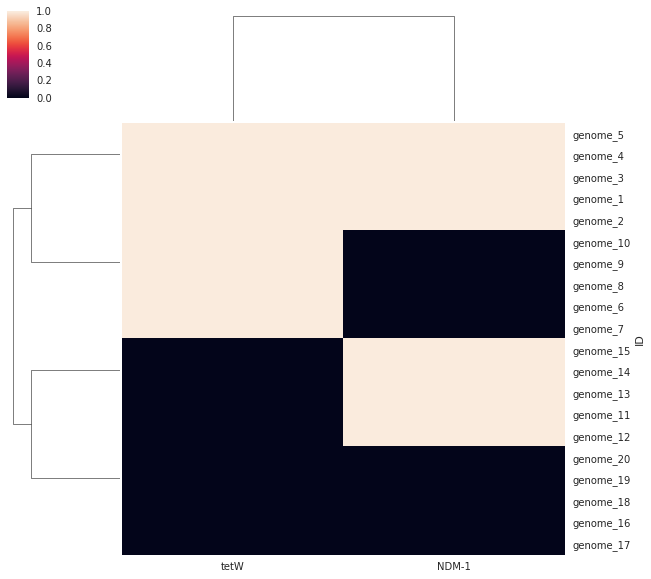

In [6]:
sns.clustermap(rgi_encoded)

Looks a pretty even spread of AROs, what about the distribution of labels (which is more important).

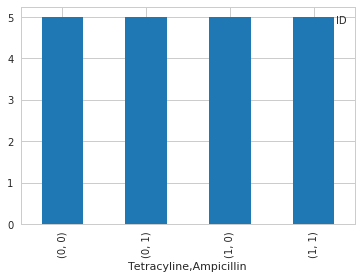

In [7]:
ast_df.reset_index().groupby(['Tetracyline', 'Ampicillin']).count().plot(kind='bar')

Perfect distribution exactly 5 resistant to both, 5 to one only and 5 to neither. Almost as if this is a contrived dataset!

## Training Test Split

We train a classifier because we want to be able to predict labels for new data we don't have them for. In other words, generalisability is really important.  To achieve this we need to be careful we don't overfit to our data.  

For this reason it is typical to split our data into groups, typically a 'training set' used to actually train our models and a 'test' set to only use at the end of the process once we've trained and chosen our model to  evaluate how well our model should work on new data its never seen before.

Sometimes a separate validation dataset is used to tune model parameters but this can also be achieved by cross-validation.  We'll skip this for now but I tend to like 5-fold cross-validation schemes where we fit our model of 4/5th of our training data and evaluate how well it performs on the 1/5th we've held out. This is then repeated for all folds. There are tons more details on this (and everything mentioned here in the scikit-learn documentation).

We'll just do a simple 80:20 training:test dataset split

In [8]:
rgi_train, rgi_test, \
    ast_train, ast_test = sklearn.model_selection.train_test_split(\
                                                  rgi_encoded, 
                                                  ast_df,
                                                  test_size=0.2,
                                                  random_state=42)

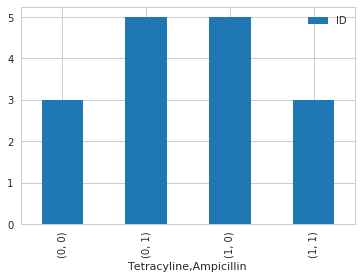

In [9]:
# it's a good idea to check our labels are still relatively evenly distributed
ast_train.reset_index().groupby(['Tetracyline', 'Ampicillin']).count().plot(kind='bar')
# even if they aren't perfect anymore as long as they are the same magnitude we
# are all good.
# If there is a problem here we can use startified test-train split schemes
# that preserve the balance of labels better
# also note this is probably far too little data to be doing this for real!

## Training a model

As the ASTs we want to predict contain multiple drugs and a genome can be resistant to more than one at a time we are trying to do a type of supervised learning known as multilabel learning.

It's overkill for this toy dataset but we are just going to use a simple random forest.

This is essentially an algorithm that learns a whole bunch of decision trees on the data and combines their output to make predictions.

In [10]:
clf = sklearn.ensemble.RandomForestClassifier()
# fit the model
clf.fit(rgi_train, ast_train)

# evaluate the training performance (should use 
# cross-validation on real data here)
rgi_train_pred = clf.predict(rgi_train)

In [11]:
# and if we look at how we've done on the training set
# its perfect because this data is synthetic and contrived
print(sklearn.metrics.classification_report(ast_train, rgi_train_pred, target_names = ['Tetracyline', 'Ampicillin']))

             precision    recall  f1-score   support

Tetracyline       1.00      1.00      1.00         8
 Ampicillin       1.00      1.00      1.00         8

avg / total       1.00      1.00      1.00        16



In a real classification analysis this is where you would use your cross-validation metrics to try and get the best performance you can by trying 
different models and different model hyperparameters. For more information on this have a look at: http://scikit-learn.org/stable/modules/cross_validation.html

As we've got perfect performance due to the perfect data I've created we can move on to evaluating our test performance

## Feature importance

One nice thing you can do with certain methods is looking at the importance of different features.  This is a bit trivial in this example (and will really just reflect their relative abundance in the training data) but can be really useful in real examples.

In [35]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(rgi_train.shape[1]):
    print("{}. feature: {} ({})".format(f + 1, rgi_train.columns[f], importances[indices[f]]))

Feature ranking:
1. feature: tetW (0.5304832372921442)
2. feature: NDM-1 (0.46951676270785575)


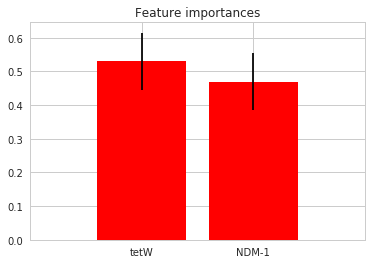

In [36]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(rgi_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks( indices, [rgi_train.columns[x] for x in indices],)
plt.xlim([-1, rgi_train.shape[1]])
plt.show()

## Test performance

In [47]:
rgi_test_pred = clf.predict(rgi_test)
print(sklearn.metrics.classification_report(ast_test, rgi_test_pred, target_names = ['Tetracyline', 'Ampicillin']))

             precision    recall  f1-score   support

Tetracyline       1.00      1.00      1.00         2
 Ampicillin       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00         4



We are still perfect precision and reclal which is nice and not common in real data. 

There are lots of different ways to evaluate our data too, a ton of different metrics are available.

In the case of our specific data we might want to use the FDA criteria i.e. essential agreement, categorical agreement, major error and very major error

In [84]:
def fda_metric(pred_ast, true_ast):
    pred_ast = pd.DataFrame(pred_ast)
    pred_ast.index = true_ast.index
    pred_ast.columns = true_ast.columns
    pred_ast = pred_ast.astype('int64')
    
    fda_perf = pd.DataFrame(index=true_ast.index, columns = ['Categorical Agreement',
                                                           'Major Disagreement',
                                                           'Very Major Disagreement'])
    fda_perf = fda_perf.fillna(0)
    for ix, ast in true_ast.iterrows():
        for drug, sir in ast.iteritems():
            if sir == pred_ast.loc[ix, drug]:
                fda_perf.loc[ix, 'Categorical Agreement'] += 1 
            elif sir == 0 and pred_ast.loc[ix, drug] == 1:
                fda_perf.loc[ix, 'Major Disagreement'] += 1
            elif sir == 1 and pred_ast.loc[ix, drug] == 0:
                fda_perf.loc[ix, 'Very Major Disagreement'] += 1
            else:
                assert False
    return fda_perf

Text(0.5,1,'FDA Performance')

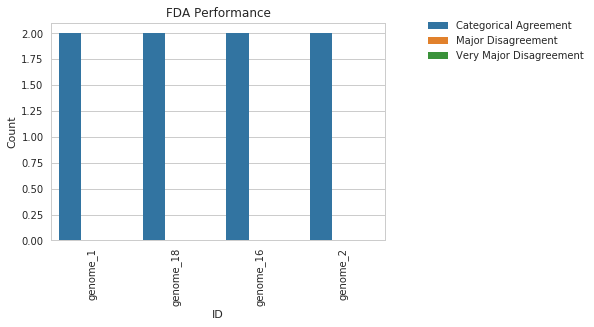

In [109]:
# alternatively you could group by drug or species or whatever
fda = fda_metric(rgi_test_pred, ast_test)
sns.barplot(data = pd.melt(fda.reset_index(), id_vars='ID', var_name=['FDA Category'], value_name='Count'),
            x='ID', y='Count', hue='FDA Category')
plt.legend(bbox_to_anchor=(1.1, 1.05))
_ = plt.xticks(rotation=90)
plt.title('FDA Performance')